# Modeling and Results

Ultimately, in the model testing, six sets of stop words are tested. All include a small subset of give aways, while the other six are standard english, top 50, top 100, english + top50, and english + top100 where top50/top100 are overlapping words contained in the top 50/100 words for each sub. These top lists have english stop words pre removed. 

Five pipelines are made, with the best results from full gridsearches used. Commented out include the final set of parameters searched for each fit type. The five pipelines correspond to CountVectoriezer/Naive Bayes, Tfidf/NaiveBayes, Tfidf/Logistic Regression, Tfidf/DecisionTree, and Tfidf/RandomForest. Each pipeline is then applied to each of tokenization set (none, Lemmatizing, stemming). Initial tuning for each pipeline was only performed on the none tokenized set. 

Finally, a LassoLR and RidgeLR were applied to all three tokenized sets. C values were searched over, and the engineered columns were added. Engineered columns weren't used in other instances because I didn't know how to properly incororate them to the pipeline. Limitations to the Lasso and Ridge fits are computer memory that were not encountered in pipline fitting. This is an area for further study. 


In [1]:
#imports
import pandas as pd
import numpy as np
import datetime as dt
import time
import requests
import matplotlib.pyplot as plt
import string
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


In [2]:
#load processed data
jokes_all = pd.read_csv('../data/jokes_processed.csv')

In [3]:
#make individual dataframes for word lists
X = jokes_all['full_text']
y = jokes_all['dad']
X_dj = jokes_all[jokes_all['dad'] == 1]['full_text']
y_dj = jokes_all[jokes_all['dad'] == 1]['dad']
X_aj = jokes_all[jokes_all['dad'] == 0]['full_text']
y_aj = jokes_all[jokes_all['dad'] == 0]['dad']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [4]:
#Count vector for dadjokes
cvec_dj = CountVectorizer(stop_words='english')
Xcv_dj = cvec_dj.fit_transform(X_dj,y_dj)
Xcv_djdf = pd.DataFrame(Xcv_dj.todense(),columns=cvec_dj.get_feature_names())
Xcv_djdf.head()

,00,000,01k,02,05,07,0mg,0nsznmdxnzu,10,100,...,𝒊𝒏,𝒍𝒊𝒌𝒆𝒏𝒆𝒅,𝒑𝒉𝒂𝒓𝒂𝒐𝒉,𝒕𝒉𝒆,𝒕𝒐,𝒚𝒐𝒖𝒏𝒈𝒆𝒔𝒕,𝙏𝙤𝙤𝙩,𝙖𝙣,𝙘𝙤𝙢𝙢𝙤𝙣,𝙞𝙣
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#Count vector for antijokes
cvec_aj = CountVectorizer(stop_words='english')
Xcv_aj = cvec_aj.fit_transform(X_aj,y_aj)
Xcv_ajdf = pd.DataFrame(Xcv_aj.todense(),columns=cvec_aj.get_feature_names())
Xcv_ajdf.head()

,00,000,00000000000000000000000000000001,00100000,003,006,00653875954571505539843239754513915896150297878399377056071435169747221107988,007,01,01100001,...,𝗺𝗶𝘀𝗹𝗲𝗮𝗱𝗶𝗻𝗴,𝗺𝗼𝗿𝗻𝗶𝗻𝗴,𝘀𝗮𝘆,𝘀𝗼𝘂𝗿𝗰𝗲𝘀,𝘀𝘁𝗮𝘁𝗲𝗱,𝘁𝗴𝗲𝘂𝗿,𝘁𝗵𝗲,𝘁𝗵𝗶𝘀,𝘁𝗼,𝘄𝗼𝗿𝗸𝗲𝗿
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#top 50 and 100 most common antijoke words and dadjoke words

top50_aj = list(Xcv_ajdf.sum().sort_values(ascending=False).head(50).index)
top50_dj = list(Xcv_djdf.sum().sort_values(ascending=False).head(50).index)
top100_aj = list(Xcv_ajdf.sum().sort_values(ascending=False).head(100).index)
top100_dj = list(Xcv_djdf.sum().sort_values(ascending=False).head(100).index)


In [7]:
#Hard code for giveaway words
# EX. "I'm not a dad", "My son told me this one", "This is an antijoke"
stop_dad = ['dad','son','daughter','son','anti','antijokes','antijoke']
english_stop = list(stopwords.words('english')) + stop_dad

In [8]:
#Make stop list for common words in the top 50 and 100

stop_50, stop_100 = stop_dad[:], stop_dad[:]
for aj in top50_aj:
    if aj in top50_dj:
        stop_50.append(aj)
for aj in top100_aj:
    if aj in top100_dj:
        stop_100.append(aj)
        

# PIPELINE

The next two cells will have:
 - Cell 1. The final tuned paramaters for the pipelines
 - Cell 2. The last set of tuning for the gridsearch. 
 
A bayesian search was also performed for some but did not accomplish much. 

In order for below, these make up:
 - Naive Bayes with Count Vectorization
 - Naive Baryes with Tf-idf
 - Logistic Regressino with Tf-idf
 - Decision Tree with with Tf-idf
 - Random Forest with Tf-idf

Only non-tokened had full gridsearches performed, and then they were applied to the different tokenization sets. This is due to limited CPU time to perform some of the fits. 

The final set is applied to all three tokenizations (none, Lemma, Porter Stem) and results are examined. 

In [9]:
#Naive Bayes with Count Vectorization
gs_pipe = Pipeline([
    ('cvec', CountVectorizer() ),
    ('nb', MultinomialNB())
])
gs_params = {'cvec__min_df': [2],
 'cvec__ngram_range': [(1, 6)],
 'cvec__stop_words': [stop_dad]
    }

#Naive Baryes with Tf-idf
gstf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB() )
])
gstf_params = {'tvec__min_df': [2],
 'tvec__ngram_range': [(1, 2)],
 'tvec__stop_words': [stop_dad]
              }
#Logistic Regressino with Tf-idf
gslr_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(random_state=42))
])
gslr_params = {
    'lr__max_iter': [100000],
 'lr__penalty': ['none'],
 'lr__solver': ['sag'],
 'tvec__min_df': [1],
 'tvec__ngram_range': [(1, 3)],
 'tvec__stop_words': [stop_dad]
}

#Decision Tree with with Tf-idf
gsdt_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier(random_state=42))
])
gsdt_params = {'dt__max_depth': [45],
 'dt__min_samples_leaf': [1],
 'dt__min_samples_split': [5],
 'tvec__min_df': [3],
 'tvec__ngram_range': [(1, 6)],
 'tvec__stop_words': [stop_dad]}

#Random Forest with Tf-idf
gsrf_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])
gsrf_params={'rf__max_depth': [30],
 'rf__max_features': ['auto'],
 'rf__min_samples_leaf': [2],
 'rf__min_samples_split': [5],
 'rf__n_estimators': [400],
 'tvec__min_df':[4],
 'tvec__ngram_range': [(1, 6)],
 'tvec__stop_words': [stop_dad]}



In [ ]:
#THESE ARE IN THE SAME ORDER

#    Naive Bayes with Count Vectorization
#    Naive Baryes with Tf-idf
#    Logistic Regressino with Tf-idf
#    Decision Tree with with Tf-idf
#    Random Forest with Tf-idf


# pipe_cvnb_params = {
#     'cvec__min_df': [2,3,4,5,6,7],
#     'cvec__stop_words': [stop_dad],
#     'cvec__ngram_range': [(1,6)]
# }

# pipe_tvec_params = {
#     'tvec__stop_words': [stop_dad],
#     'tvec__min_df': [1, 2, 3],
#     'tvec__ngram_range': [(1,1), (1,2),(1,3)]
# }

# pipe_logcv_params = {
#     'tvec__stop_words': [stop_dad],
#     'tvec__min_df': [1, 2, 3],
#     'tvec__ngram_range': [(1,1), (1,2),(1,3)],
#     'lr__penalty': ['none'],
#     'lr__max_iter': [100000],
#     'lr__solver':['sag']
# }

# dt_params = {'tvec__stop_words': [stop_dad],
#              'tvec__min_df': [1,3,5,7],
#              'tvec__ngram_range': [(1,6)],
#              'dt__max_depth': [20,25,30,35,40,45,60],
#              'dt__min_samples_split': [5, 10, 15, 20, 25, 30, 35,40,45,50],
#              'dt__min_samples_leaf': [1,2],
# }

# rf_params = {
#              'tvec__stop_words': [stop_dad],
#              'tvec__min_df': [3,4],
#              'tvec__ngram_range': [(1,6)],
#              'rf__n_estimators': [200,300,400],
#              'rf__max_depth': [30],
#              'rf__min_samples_split': [4,5,6,7],
#              'rf__min_samples_leaf': [2],
#              'rf__max_features': ['auto']
# }


In [10]:
#lemma train/test set
Xlem = jokes_all['lemon']
ylem = jokes_all['dad']
Xlem_train, Xlem_test, ylem_train, ylem_test = train_test_split(Xlem,ylem,test_size=0.2,random_state=42)


In [11]:
#Porter stem train/test set
Xport = jokes_all['porter']
yport = jokes_all['dad']

Xport_train, Xport_test, yport_train, yport_test = train_test_split(Xport,yport,test_size=0.2,random_state=42)


In [12]:
#Function for displaying and saving the results
def plot_cfm(fit,xtrain,ytrain,xtest,ytest):
    print(fit.score(xtrain,ytrain),fit.score(xtest,ytest))
    preds = fit.predict(xtest)

    tn, fp, fn, tp = confusion_matrix(ytest, preds).ravel()
    plot_confusion_matrix(fit, xtest, ytest, cmap='Blues');
    return [fit.score(xtrain,ytrain)],[fit.score(xtest,ytest)]

In [13]:
#dataframe for analyzing fit results
df_fitresults = pd.DataFrame()

# FITTING MODELS

With pipelines formed, the following 15 cells do fits and save the results in this order:
No Token - 
 - Naive Bayes with Count Vectorization
 - Naive Baryes with Tf-idf
 - Logistic Regressino with Tf-idf
 - Decision Tree with with Tf-idf
 - Random Forest with Tf-idf

Lemmatized - 
 - Naive Bayes with Count Vectorization
 - Naive Baryes with Tf-idf
 - Logistic Regressino with Tf-idf
 - Decision Tree with with Tf-idf
 - Random Forest with Tf-idf

Porter Stemmed - 
 - Naive Bayes with Count Vectorization
 - Naive Baryes with Tf-idf
 - Logistic Regressino with Tf-idf
 - Decision Tree with with Tf-idf
 - Random Forest with Tf-idf

Fit results are added to `df_fitresults`


0.876926259178819 0.707196029776675


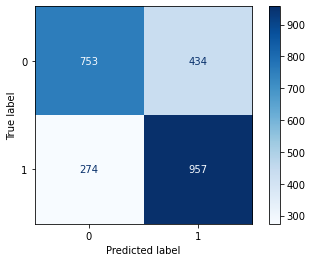

In [14]:
results = {'fitter':['nb_cv'],'token':['no']}

gs = GridSearchCV(gs_pipe,gs_params,cv =5)
gs.fit(X_train,y_train)
results['train'],results['test']=plot_cfm(gs,X_train,y_train,X_test,y_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.9053676698727893 0.7303556658395368


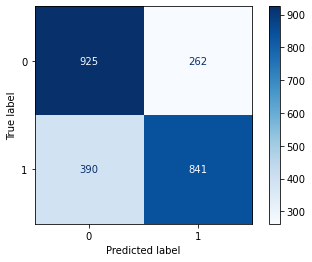

In [15]:
results = {'fitter':['nb_tf'],'token':['no']}

gstf = GridSearchCV(gstf_pipe,gstf_params,cv =5)
gstf.fit(X_train,y_train)
results['train'],results['test']=plot_cfm(gstf,X_train,y_train,X_test,y_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.9989657668838556 0.7440033085194375


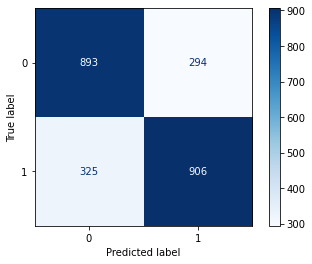

In [16]:
results = {'fitter':['logreg'],'token':['no']}

gslr = GridSearchCV(gslr_pipe,gslr_params,cv =5)
gslr.fit(X_train,y_train)
results['train'],results['test']=plot_cfm(gslr,X_train,y_train,X_test,y_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.8874754369634916 0.6451612903225806


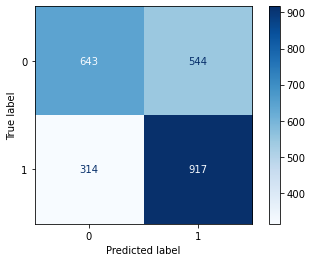

In [17]:
results = {'fitter':['dectree'],'token':['no']}

gsdt = GridSearchCV(gsdt_pipe,gsdt_params,cv =5)
gsdt.fit(X_train,y_train)
results['train'],results['test']=plot_cfm(gsdt,X_train,y_train,X_test,y_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.7875685179439446 0.7138130686517783


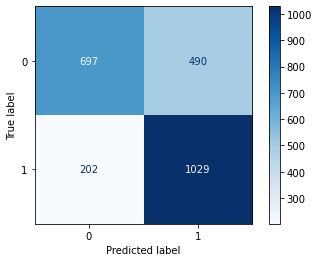

In [18]:
results = {'fitter':['randfor'],'token':['no']}

gsrf = GridSearchCV(gsrf_pipe,gsrf_params,cv =5)
gsrf.fit(X_train,y_train)
results['train'],results['test']=plot_cfm(gsrf,X_train,y_train,X_test,y_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

In [19]:
df_fitresults

,fitter,token,train,test
0,nb_cv,no,0.876926,0.707196
0,nb_tf,no,0.905368,0.730356
0,logreg,no,0.998966,0.744003
0,dectree,no,0.887475,0.645161
0,randfor,no,0.787569,0.713813


0.879304995345951 0.7133995037220844


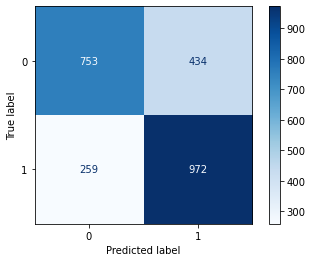

In [20]:
results = {'fitter':['nb_cv'],'token':['lem']}

gs_lem = GridSearchCV(gs_pipe,gs_params,cv =5)
gs_lem.fit(Xlem_train,ylem_train)
results['train'],results['test']=plot_cfm(gs_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.9048505533147171 0.7224979321753515


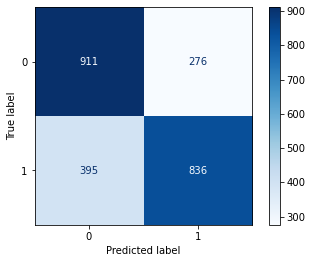

In [21]:
results = {'fitter':['nb_tf'],'token':['lem']}

gstf_lem = GridSearchCV(gstf_pipe,gstf_params,cv =5)
gstf_lem.fit(Xlem_train,ylem_train)
results['train'],results['test']=plot_cfm(gstf_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.99906919019547 0.7411083540115798


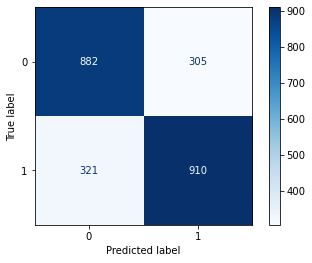

In [22]:
results = {'fitter':['logreg'],'token':['lem']}

gslr_lem = GridSearchCV(gslr_pipe,gslr_params,cv =5)
gslr_lem.fit(Xlem_train,ylem_train)
results['train'],results['test']=plot_cfm(gslr_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.8914055228048402 0.6513647642679901


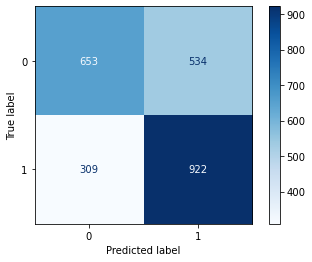

In [23]:
results = {'fitter':['dectree'],'token':['lem']}

gsdt_lem = GridSearchCV(gsdt_pipe,gsdt_params,cv =5)
gsdt_lem.fit(Xlem_train,ylem_train)
results['train'],results['test']=plot_cfm(gsdt_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.7895335608646189 0.705955334987593


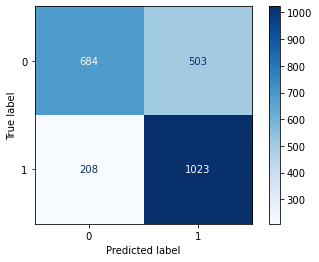

In [24]:
results = {'fitter':['randfor'],'token':['lem']}

gsrf_lem = GridSearchCV(gsrf_pipe,gsrf_params,cv =5)
gsrf_lem.fit(Xlem_train,ylem_train)
results['train'],results['test']=plot_cfm(gsrf_lem,Xlem_train,ylem_train,Xlem_test,ylem_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.8743406763884579 0.7043010752688172


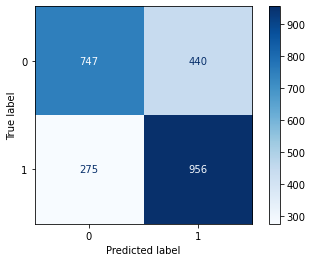

In [25]:
results = {'fitter':['nb_cv'],'token':['port']}

gs_port = GridSearchCV(gs_pipe,gs_params,cv =5)
gs_port.fit(Xport_train,yport_train)
results['train'],results['test']=plot_cfm(gs_port,Xport_train,yport_train,Xport_test,yport_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.9052642465611749 0.7241521918941274


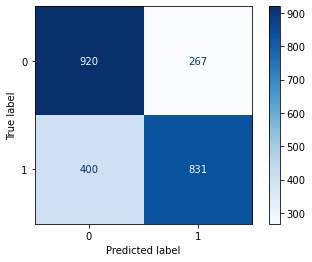

In [26]:
results = {'fitter':['nb_tf'],'token':['port']}

gstf_port = GridSearchCV(gstf_pipe,gstf_params,cv =5)
gstf_port.fit(Xport_train,yport_train)
results['train'],results['test']=plot_cfm(gstf_port,Xport_train,yport_train,Xport_test,yport_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.99906919019547 0.73904052936311


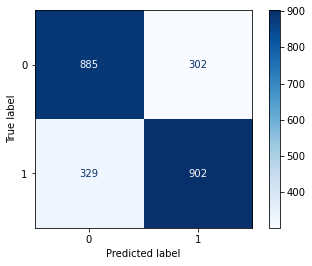

In [27]:
results = {'fitter':['logreg'],'token':['port']}

gslr_port = GridSearchCV(gslr_pipe,gslr_params,cv =5)
gslr_port.fit(Xport_train,yport_train)
results['train'],results['test']=plot_cfm(gslr_port,Xport_train,yport_train,Xport_test,yport_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.886648050470576 0.6488833746898263


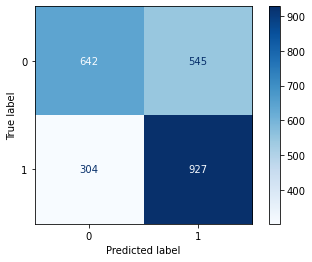

In [28]:
results = {'fitter':['dectree'],'token':['port']}

gsdt_port = GridSearchCV(gsdt_pipe,gsdt_params,cv =5)
gsdt_port.fit(Xport_train,yport_train)
results['train'],results['test']=plot_cfm(gsdt_port,Xport_train,yport_train,Xport_test,yport_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

0.7873616713207157 0.7158808933002482


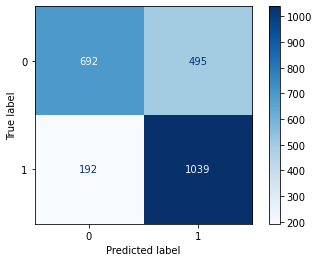

In [29]:
results = {'fitter':['randfor'],'token':['port']}

gsrf_port = GridSearchCV(gsrf_pipe,gsrf_params,cv =5)
gsrf_port.fit(Xport_train,yport_train)
results['train'],results['test']=plot_cfm(gsrf_port,Xport_train,yport_train,Xport_test,yport_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

# Regularized Logistic Regression
The immediate cells process the data to perform Regularized Logistic Regression for the three token sets. First each set undergoes:
 - Train test split with addition of new features
 - Count vectorization to which my computer can handle (memory not enough)
 - Drop index to handle issues with trying to recombine after vectorization


In [30]:
#standard scaler for use
ss = StandardScaler(with_mean=False)

In [64]:
#set up lem with added features
Xlem = jokes_all[['lemon','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
ylem = jokes_all['dad']

Xlem_train, Xlem_test, ylem_train, ylem_test = train_test_split(Xlem,ylem,test_size=0.2,random_state=42)

In [32]:
#Lemmatize and tfidf
cv_lem = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
Xlem_train_cv = cv_lem.fit_transform(Xlem_train['lemon'])

#reset index to fix mismatch issue
Xlem_train_df = pd.DataFrame(Xlem_train_cv.todense(),
                              columns=cv_lem.get_feature_names()).reset_index()

Xlem_train_sent = Xlem_train[['ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']].reset_index()
#combine
Xlem_train_df = pd.concat([Xlem_train_df,Xlem_train_sent],axis = 1)

In [33]:
#lemma
Xlem_test_cv = cv_lem.transform(Xlem_test['lemon'])
#reset index to fix mismatch issue
Xlem_test_df = pd.DataFrame(Xlem_test_cv.todense(),
                             columns=cv_lem.get_feature_names()).reset_index()

Xlem_test_sent = Xlem_test[['ft_wc','ft_length',
                              'sent_compound','sent_pos',
                              'sent_neg','sent_neu']].reset_index()
#combine
Xlem_test_df = pd.concat([Xlem_test_df,Xlem_test_sent],axis = 1)
print(Xlem_train_df.shape,Xlem_test_df.shape)

(9669, 15324) (2418, 15324)


In [34]:
#drop index that was added
Xlem_train_df.drop(columns='index',inplace=True)
Xlem_test_df.drop(columns='index',inplace=True)

In [35]:
#new train test with added features
Xport = jokes_all[['porter','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
yport = jokes_all['dad']

Xport_train, Xport_test, yport_train, yport_test = train_test_split(Xport,yport,test_size=0.2,random_state=42)

In [36]:
#tfidf that my comp can handle
cv_port = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
Xport_train_cv = cv_port.fit_transform(Xport_train['porter'])
#reset index and make new DF
Xport_train_df = pd.DataFrame(Xport_train_cv.todense(),
                              columns=cv_port.get_feature_names()).reset_index()

Xport_train_sent = Xport_train[['ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']].reset_index()
#combine
Xport_train_df = pd.concat([Xport_train_df,Xport_train_sent],axis = 1)

In [37]:
#same as above for test
Xport_test_cv = cv_port.transform(Xport_test['porter'])
Xport_test_df = pd.DataFrame(Xport_test_cv.todense(),
                             columns=cv_port.get_feature_names()).reset_index()

Xport_test_sent = Xport_test[['ft_wc','ft_length',
                              'sent_compound','sent_pos',
                              'sent_neg','sent_neu']].reset_index()

Xport_test_df = pd.concat([Xport_test_df,Xport_test_sent],axis = 1)
print(Xport_train_df.shape,Xport_test_df.shape)

(9669, 15203) (2418, 15203)


In [38]:
#drop index
Xport_train_df.drop(columns='index',inplace=True)
Xport_test_df.drop(columns='index',inplace=True)

Third time is the charm, comments are as above

In [39]:
X = jokes_all[['full_text','ft_wc','ft_length','sent_compound','sent_pos','sent_neg','sent_neu']]
y = jokes_all['dad']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [40]:
cv_ = TfidfVectorizer(min_df=4,ngram_range=(1,6),stop_words=stop_dad)
X_train_cv = cv_.fit_transform(X_train['full_text'])

X_train_df = pd.DataFrame(X_train_cv.todense(),
                              columns=cv_.get_feature_names()).reset_index()

X_train_sent = X_train[['ft_wc','ft_length',
                                'sent_compound','sent_pos',
                                'sent_neg','sent_neu']].reset_index()

X_train_df = pd.concat([X_train_df,X_train_sent],axis = 1)

In [41]:
X_test_cv = cv_.transform(X_test['full_text'])
X_test_df = pd.DataFrame(X_test_cv.todense(),
                             columns=cv_.get_feature_names()).reset_index()

X_test_sent = X_test[['ft_wc','ft_length',
                              'sent_compound','sent_pos',
                              'sent_neg','sent_neu']].reset_index()

X_test_df = pd.concat([X_test_df,X_test_sent],axis = 1)
print(X_train_df.shape,X_test_df.shape)

(9669, 15403) (2418, 15403)


In [42]:
X_train_df.drop(columns='index',inplace=True)
X_test_df.drop(columns='index',inplace=True)

# RIDGE AND LASSO

Perform a ridge `lr` and lasso `lr2` on all of the data sets. Originally had done a `LogisticRegressionCV` to scan penalties, and saved the optimal one. 

Goes as follows:

No token:
 - Standardize
 - Make, fit, and check results Lasso
 - Make, fit, and check results Ridge
 
Porter Stem:
 - Standardize
 - Make, fit, and check results Lasso
 - Make, fit, and check results Ridge
 
Lemma:
 - Standardize
 - Make, fit, and check results Lasso
 - Make, fit, and check results Ridge
 

In [43]:
Ztrain = ss.fit_transform(X_train_df,y_train)
Ztest = ss.transform(X_test_df)
print(Ztrain.shape,Ztest.shape)

(9669, 15401) (2418, 15401)


In [44]:
lr = LogisticRegression(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',C=0.03162278)

0.9478746509463233 0.7100909842845327


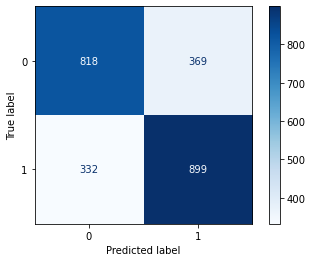

In [45]:
lr.fit(Ztrain,y_train)
results = {'fitter':['lasso'],'token':['no']}
results['train'],results['test']=plot_cfm(lr,Ztrain,y_train,Ztest,y_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

In [46]:
lr2 = LogisticRegression(random_state=42,penalty = 'l2',max_iter = 100000,
                              solver = 'liblinear',C=1.99526231e-05)

0.888509670079636 0.7233250620347395


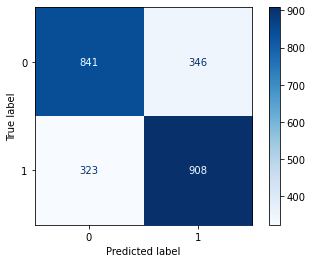

In [47]:
lr2.fit(Ztrain,y_train)
results = {'fitter':['ridge'],'token':['no']}
results['train'],results['test']=plot_cfm(lr2,Ztrain,y_train,Ztest,y_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

In [48]:
Ztrain = ss.fit_transform(Xport_train_df,yport_train)
Ztest = ss.transform(Xport_test_df)
print(Ztrain.shape,Ztest.shape)

(9669, 15201) (2418, 15201)


In [49]:
lr = LogisticRegression(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',C=0.01778279)

0.8647223084083152 0.717535153019024


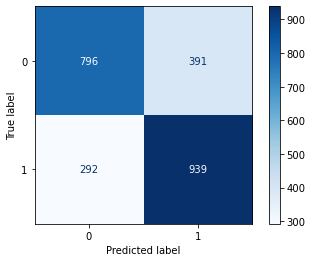

In [50]:
lr.fit(Ztrain,yport_train)
results = {'fitter':['lasso'],'token':['port']}
results['train'],results['test']=plot_cfm(lr,Ztrain,yport_train,Ztest,yport_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

In [51]:
lr2 = LogisticRegression(random_state=42,penalty = 'l2',max_iter = 100000,
                              solver = 'liblinear',C=1.58489319e-05)

0.8840624676802151 0.7253928866832092


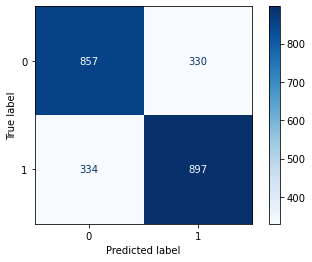

In [52]:
lr2.fit(Ztrain,yport_train)
results = {'fitter':['ridge'],'token':['port']}
results['train'],results['test']=plot_cfm(lr2,Ztrain,yport_train,Ztest,yport_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

In [53]:
Ztrain = ss.fit_transform(Xlem_train_df,ylem_train)
Ztest = ss.transform(Xlem_test_df)
print(Ztrain.shape,Ztest.shape)

(9669, 15322) (2418, 15322)


In [54]:
lr = LogisticRegression(random_state=42,penalty = 'l1',max_iter = 100000,
                              solver = 'liblinear',C=0.03162278)

0.9465301478953356 0.7138130686517783


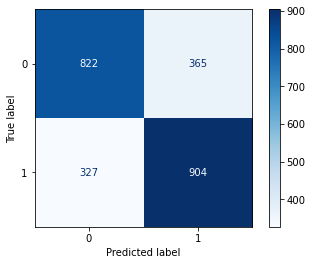

In [55]:
lr.fit(Ztrain,ylem_train)
results = {'fitter':['lasso'],'token':['lem']}
results['train'],results['test']=plot_cfm(lr,Ztrain,ylem_train,Ztest,ylem_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

In [56]:
lr2 = LogisticRegression(random_state=42,penalty = 'l2',max_iter = 100000,
                              solver = 'liblinear',C=2.51188643e-05)

0.8962664184507187 0.7241521918941274


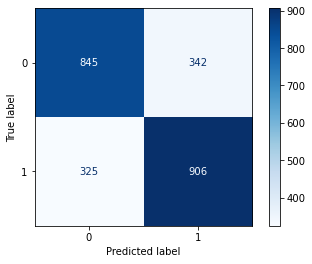

In [57]:
lr2.fit(Ztrain,ylem_train)
results = {'fitter':['ridge'],'token':['lem']}
results['train'],results['test']=plot_cfm(lr2,Ztrain,ylem_train,Ztest,ylem_test)
df_fitresults = pd.concat([df_fitresults,pd.DataFrame(results,index=None)])

In [58]:
#Reset index
df_fitresults = df_fitresults.reset_index().drop(columns='index')

In [59]:
#save fit results
df_fitresults.to_csv('../data/fit_results.csv',index=False)

In [60]:
#nicer Axis Labels
fitters = ['Naive Bayes\nCountV','Naive Bayes\nTf-idf','Logistic\nRegression','Decision\nTree','Random\nForest','RidgeLR','LassoLR']

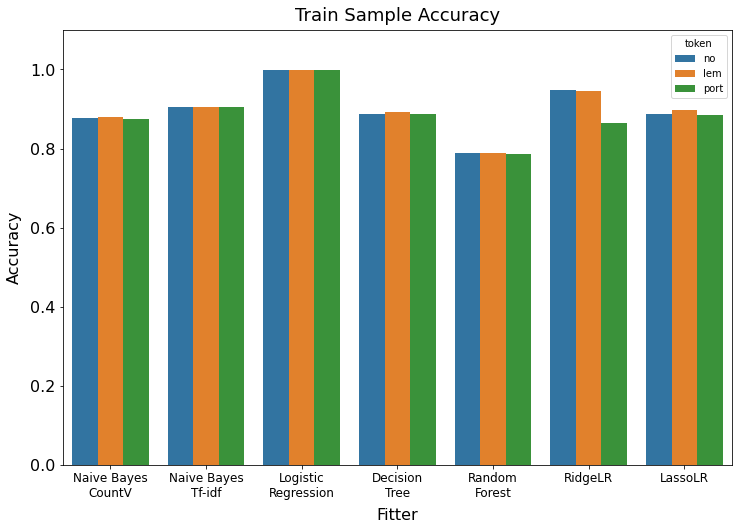

In [61]:
#plot the results for training

fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x = df_fitresults['fitter'],y=df_fitresults['train'],hue=df_fitresults['token'])
plt.title('Train Sample Accuracy', fontsize = 18, pad = 9)
plt.xlabel('Fitter', fontsize = 16, labelpad =8)
plt.xticks(fontsize=12)
plt.ylabel('Accuracy', fontsize = 16, labelpad = 8)
plt.yticks(fontsize=16);
plt.ylim(0,1.1);
ax.set_xticklabels(fitters);   

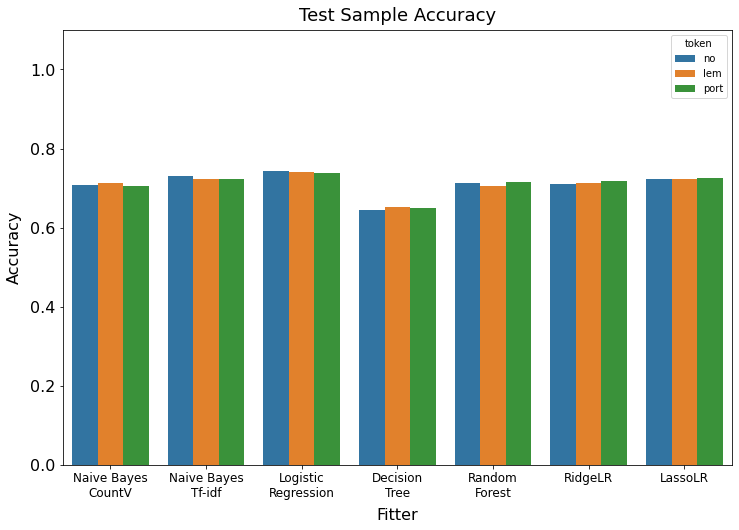

In [62]:
#plot the results for testing

fig = plt.figure(figsize=(12,8))
ax = sns.barplot(x = df_fitresults['fitter'],y=df_fitresults['test'],hue=df_fitresults['token'])
plt.title('Test Sample Accuracy', fontsize = 18, pad = 9)
plt.xlabel('Fitter', fontsize = 16, labelpad =8)
plt.xticks(fontsize=12)
plt.ylabel('Accuracy', fontsize = 16, labelpad = 8)
plt.yticks(fontsize=16);
plt.ylim(0,1.1);
ax.set_xticklabels(fitters);   

Depending on the fit each tokenization has its chance to do better than others, but no token and porter stemming perform the best

Logistic Regression performed the best, may have gotten better results if more time to be able to throw more complete fits at the set, and better engineer information. My three top fits are: 
 - No token, Logisitic regression (Best Accuracy)
 <img src="../images/gslr.png">
 - No token, Naive Bayes (Highest Specificity)
 <img src="../images/gstf.png">
 -Porter Stem, Random Forest (Highest Recall)
 <img src="../images/gsrf_port.png">